In [1]:
# https://colab.research.google.com/drive/193Nvmuo49o2flNl1g2Qlj_laR-EM1ZB7#scrollTo=zXpAf8H6qTrO

import re
import math
import pandas as pd
import jieba
from collections import OrderedDict
import collections
import gensim
import spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint

#Importing some plotting tools to aid in visualisation

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\student\AppData\Roaming\Python\Python310\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [2]:


jobs7 = pd.read_csv('./job7_4groups.csv', encoding='utf-8-sig')

print(len(jobs7['職位_'].values))
collections.Counter(jobs7['職位_'])

# 按照職位群切割資料表
job7_c1 = jobs7[jobs7["職位_"] == '職位 I'].dropna().reset_index()
job7_c2 = jobs7[jobs7["職位_"] == '職位 II'].dropna().reset_index()
job7_c3 = jobs7[jobs7["職位_"] == '職位 III'].dropna().reset_index()
job7_c4 = jobs7[jobs7["職位_"] == '職位 IV'].dropna().reset_index()

# 定義特殊符號
r_1 = r'https?://[a-zA-Z0-9./_%-@=]+|[a-zA-Z0-9]+@[a-zA-Z0-9.]+|@[a-zA-Z0-9.]+|\d\.|\(\d\)'
r_2 = r'，|,|。|…|！|!|？|\?|、|､|；|【|】|〖|〗|「|」|｢|:|：|;|；|＆|&|\(|（|\)|）|{|}|・|．|<|>|｜|_|-|—|–|╴|￣|\[|]|［|］|\*|%|~|～|\'|\"|{|}|｛|｝|\^|⌃|\$|\||●|•|·|°|★|✦|❖|￭|■|◆|※|✓|√|⇧|⌘|＝|=|@|ž|\r'

# 定義停頓詞
stop = r'的|你|妳|我|他|們|您|這個|那個|與|和|或|及|之|等|都|不只|是|以及|每次|提供|例如|並|者|又|至|最|於|需|需要|而且|且|目前|尋找|想找|尤佳|更|佳|希望|職缺|公司|工作|內容|職務|面試|面談|人才|履歷|職位|包含|一間|具備|熟悉|熟練|成立|主要|單位|眾多|負責|歡迎|加入|至少|使用|相關|擔任|回覆|對於|協助|辦理|事務|執行|關於|以下|其他|致力|身為|簡介|企業|另行|懂|非常|謝謝|帶來|若|如果|如下|未填寫|不拘|獎金|加班|薪資|補助|第一'
stop_eng = r'\ba\b|\bi\b|\byou\b|\bwe\b|\bis\b|\bare\b|\bwas\b|\bwere\b|\band\b|\bthe\b|\bin\b|\bfor\b|\bon\b|\bto\b|\bat\b|\bof\b|\bfujitsu\b|\bit\b|\bour\b|\byour\b|\bmy\b|\bby\b|\bthat\b|\bwith\b|\bas\b|\ban\b|\bteam\b|\bwill\b|\bor\b'
stop_jap = r'[ぁ-んァ-ンｧ-ﾝﾞﾟ｡]'


# 新增欄位
job7_c1["content"] = None
job7_c2["content"] = None
job7_c3["content"] = None
job7_c4["content"] = None


# 合併 => 工作內容/工作技能/其他條件
for i in range(len(job7_c1)):
    job7_c1.loc[i, 'content'] = job7_c1.loc[i, '工作內容'] + job7_c1.loc[i, '其他條件'] + job7_c1.loc[i, '工作技能']

for i in range(len(job7_c2)):
    job7_c2.loc[i, 'content'] = job7_c2.loc[i, '工作內容'] + job7_c2.loc[i, '其他條件'] + job7_c2.loc[i, '工作技能']

for i in range(len(job7_c3)):
    job7_c3.loc[i, 'content'] = job7_c3.loc[i, '工作內容'] + job7_c3.loc[i, '其他條件'] + job7_c3.loc[i, '工作技能']

for i in range(len(job7_c4)):
    job7_c4.loc[i, 'content'] = job7_c4.loc[i, '工作內容'] + job7_c4.loc[i, '其他條件'] + job7_c4.loc[i, '工作技能']
    
    
    
# 資料清整 => 拔停頓詞, 特殊符號   
lst = [job7_c1, job7_c2, job7_c3, job7_c4]

# 拔特殊符號
for i in lst:
    for j in range(len(i)):
        c00 = re.sub(r_1, ' ', i.loc[j, 'content'])
        c01 = re.sub(r_2, ' ', c00)
        c02 = re.sub(r'^\s+', '', c01)
        i.loc[j, 'content'] = c02
        
# 拔停頓詞       
for i in lst:
    for j in range(len(i)):
        c10 = re.sub(stop, ' ', i.loc[j, 'content'])
        c11 = c10.lower()
        c12 = re.sub(stop_eng, ' ', c11)
        c13 = re.sub(stop_jap, ' ', c12)
        c14 = re.sub(r'\s+', ' ', c13)
        i.loc[j, 'content'] = c14



57127


In [3]:
job7_c1.loc[1,'content']

'從事電腦bios bios 應用軟體開發 除錯 維護 bios應用規格 流程撰寫 熟c語言 熟組合語言 對pc設計具有興趣 熱忱 具強烈學習能力 意願 對pc設計具有高度興趣 熱忱 瞭解bios 領域 經驗 雖非資訊 科系 亦 主動應徵本 地點 台北 台中 詳情面議 '

In [4]:
# # jieba 加字典
# # 新增詞庫
# with open(r'C:\sunny.workstation\Sunny.Python\期末專題\word2vec所有東西\trad_dict.txt', 'r', encoding='utf-8') as infile:
#     d = infile.read()
# for word in d:
#     jieba.add_word(word)

# path_dic = [r'C:\sunny.workstation\Sunny.Python\期末專題\word2vec所有東西\wiki_lower.txt',
#             r'C:\sunny.workstation\Sunny.Python\期末專題\word2vec所有東西\ee_lower.txt',
#             r'C:\sunny.workstation\Sunny.Python\期末專題\word2vec所有東西\computer_lower.txt',
#             r'C:\sunny.workstation\Sunny.Python\期末專題\word2vec所有東西\statistics_lower.txt',
#             r'C:\sunny.workstation\Sunny.Python\期末專題\word2vec所有東西\library_lower.txt']
# for dic in path_dic:
#     with open(dic, 'r', encoding='utf-8') as infile:
#         d = infile.read()
#     for word in d:
#         jieba.add_word(word+' 1000')

In [5]:
jieba.add_word('asp.net')
jieba.add_word('區塊鍊')
jieba.add_word('區塊鏈')
jieba.add_word('加分項')
jieba.add_word('加分')
jieba.add_word('sas')
jieba.add_word('aml')
jieba.add_word('es6+')
jieba.add_word('信託')
jieba.add_word('大數據')
jieba.add_word('撰寫')
jieba.add_word('身體')
jieba.add_word('公佈')
jieba.add_word('方向')
jieba.add_word('吸引力')
jieba.add_word('為什麼')
jieba.add_word('製作')
jieba.add_word('mysql')
jieba.add_word('mssql')
jieba.add_word('sqlite')
jieba.add_word('rfp')
jieba.add_word('新創')
jieba.add_word('工程師')
jieba.add_word('帶領')
jieba.add_word('佈署')
jieba.add_word('製作')
jieba.add_word('追蹤')
jieba.add_word('開發')
jieba.add_word('經驗')
jieba.add_word('優化')
jieba.add_word('作業')
jieba.add_word('透過')
jieba.add_word('程式碼')
jieba.add_word('回應')
jieba.add_word('不確定')
jieba.add_word('委託')
jieba.add_word('接下來')
jieba.add_word('壓力測試')
jieba.add_word('沒有')
jieba.add_word('比特幣')
jieba.add_word('彼特幣')
jieba.add_word('最大值')
jieba.add_word('最小值')
jieba.add_word('訓練集')
jieba.add_word('邏輯式迴歸')
jieba.add_word('邏輯式回歸')
jieba.add_word('羅吉斯迴歸')
jieba.add_word('羅吉斯回歸')
jieba.add_word('迴歸')
jieba.add_word('線性迴歸')
jieba.add_word('線性回歸')
jieba.add_word('特徵')
jieba.add_word('程式碼')
jieba.add_word('物件導向')
jieba.add_word('前端')
jieba.add_word('後端')
jieba.add_word('全端')
jieba.add_word('前後端')
jieba.add_word('工程師')
jieba.add_word('分類器')
jieba.add_word('機器學習')
jieba.add_word('深度學習')
jieba.add_word('演算法')
jieba.add_word('監督式')
jieba.add_word('機率')
jieba.add_word('人工智慧')
jieba.add_word('決策樹')
jieba.add_word('數據分析')
jieba.add_word('資料探勘')
jieba.add_word('正規化')
jieba.add_word('過度配適')
jieba.add_word('特徵工程')
jieba.add_word('特徵選取')
jieba.add_word('svm')
jieba.add_word('random forest')
jieba.add_word('隨機森林')
jieba.add_word('sklearn')
jieba.add_word('矩陣')
jieba.add_word('自然語言處理')
jieba.add_word('logistic regression')
jieba.add_word('linear regression')
jieba.add_word('k means')
jieba.add_word('主成分分析')
jieba.add_word('統計')
jieba.add_word('maximum likelihood estimation')
jieba.add_word('reinforcement learning')
jieba.add_word('decision tree')
jieba.add_word('id3')
jieba.add_word('naive bayes')
jieba.add_word('polynomial regression')
jieba.add_word('lasso regression')
jieba.add_word('ridge regression')
jieba.add_word('elasticnet regression')
jieba.add_word('網頁設計')
jieba.add_word('專案管理')
jieba.add_word('梯度下降法')
jieba.add_word('資安')
jieba.add_word('word embedding')
jieba.add_word('網路爬蟲')
jieba.add_word('資工')
jieba.add_word('叢集')
jieba.add_word('迴歸樹')
jieba.add_word('回歸樹')
jieba.add_word('分類樹')
jieba.add_word('管理員')
jieba.add_word('系統')
jieba.add_word('安裝')
jieba.add_word('邏輯斯迴歸')
jieba.add_word('邏輯斯回歸')
jieba.add_word('裝置')
jieba.add_word('多人')
jieba.add_word('多工')
jieba.add_word('人員')
jieba.add_word('系統化')
jieba.add_word('系統化架構')
jieba.add_word('c語言')
jieba.add_word('諮詢')
jieba.add_word('複製')
jieba.add_word('防火牆')
jieba.add_word('資料庫')
jieba.add_word('vue.js')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\student\AppData\Local\Temp\jieba.cache
Loading model cost 0.487 seconds.
Prefix dict has been built successfully.


In [6]:
job7_c1.loc[1,'content']


'從事電腦bios bios 應用軟體開發 除錯 維護 bios應用規格 流程撰寫 熟c語言 熟組合語言 對pc設計具有興趣 熱忱 具強烈學習能力 意願 對pc設計具有高度興趣 熱忱 瞭解bios 領域 經驗 雖非資訊 科系 亦 主動應徵本 地點 台北 台中 詳情面議 '

In [7]:
#精確模式（Default Mode)

seg_list = []
lst = [job7_c1, job7_c2, job7_c3, job7_c4]

for i in lst:
    for j in range(len(i)):
        seg_list = jieba.cut(i.loc[j,'content'], cut_all=False)
        i.loc[j,'content'] = " ".join(seg_list)       

In [8]:
job7_c1["content"]

0       微控制器 程式 設計 有 興趣   人員   量測   控制   通訊   人機 介面 ...
1     從事 電腦 bios   bios   應用 軟體 開發   除錯   維護   bios ...
2     kernel   code   developing   uefi   core   imp...
3     一   軟體 / 韌體 bios 助理 工程師   完成 指派   bios   開發 任務...
4     系微   insyde   software   1998 年   軟體 工程 諮詢 服務 ...
5     一   chromebook 軟體 / 韌體 bios 助理 工程師   完成 指派   g...
6     電機 電子 工程   資訊 工程   科系   修習過 c語言   英文 溝通 能力   能...
7     參   專案 開發 過程   含 nb   pc   bios 程式 開發   除錯   維...
8     參   專案 開發 過程   含 nb   pc   bios 程式 開發   除錯   維...
9     領導 工程 開發 團隊   bios   專案 開發   專案 問題 除錯   客 製 化 ...
10    deep   diving   server   features   such   ipm...
11    study   server   hardware   architecture   tre...
12    windows   /   linux   應用 程式 開發   windows   /  ...
13      軟體   分析   設計   程式 撰寫   規劃   軟體 架構   模組   設計 ...
14      針對 chromebook 專案 產品   系統 平台   韌體   開發   除錯  ...
15    針對   設計 主板   bios 開發   研發 出來 bios   除錯   研發 階段...
16    從事 ipc 產品 軟 / 韌體 程式 開發   問題 解決   除錯   維護   bio...
17      新 開產品 韌體 開發   跟據 硬體 設備   各項 輸入 / 輸出   in

In [9]:
job7_c1.loc[1,'content']

'從事 電腦 bios   bios   應用 軟體 開發   除錯   維護   bios 應用 規格   流程 撰寫   熟 c語言   熟 組合 語言   對 pc 設計 具有 興趣   熱忱   具強烈 學習 能力   意願   對 pc 設計 具有 高度 興趣   熱忱   瞭解 bios   領域   經驗   雖非 資訊   科系   亦   主動應 徵本   地點   台北   台 中   詳 情面 議  '

In [10]:
r_3 = r'\b\d+\b'

for k in lst:
    # n = 0
    for j in range(len(k)):
        # print(j)
        c20 = re.sub(r_3, ' ', k.loc[j, 'content'])
        c21 = c20.split()
        c_list = []
        # k.at[j,'content'] = c21

        i = len(c21)-1

        while i>=0:
            if 'c' not in c21[i]:
                c21[i] = c21[i].replace("#", "")
                c21[i] = c21[i].replace("+", "")
            if len(c21[i]) <= 1:
                i-=1
                continue
            if c21[i] == '.' or c21[i] == '..'or c21[i] == '...' or c21[i] == '....' or c21[i] == '.....' \
            or c21[i] == '......'or c21[i] == '.......'or c21[i] == '........'or c21[i] == '.........'or c21[i] == '..........'\
            or c21[i] == '/' or c21[i] == '//' or c21[i] == '\\' or c21[i] == '\\\\'\
            or (not c21[i].isprintable()):
                i -= 1
                continue
            if c21[i] == 'co' and c21[i-1] == '/' and c21[i-2] == 'fi':
                if c21[i-3] == 'hana':
                    c_list.append('s/4 hana fi/co')
                    i -= 7
                    continue
                elif c21[i-3] == '4' and c21[i-4] == '\/' and c21[i-5] == 's':
                    c_list.append('s/4 fi/co')
                    i -= 6
                    continue
            if c21[i] == 'hana':
                if c21[i-1] == '4' and c21[i-2] == '/' and c21[i-3] == 's':
                    i -= 4
                    continue
            c_list.append(c21[i])
            i -= 1
        k.at[j, 'content'] = c_list[::-1]




<>:32: DeprecationWarning: invalid escape sequence '\/'
<>:32: DeprecationWarning: invalid escape sequence '\/'
C:\Users\student\AppData\Local\Temp\ipykernel_9128\1072374956.py:32: DeprecationWarning: invalid escape sequence '\/'
  elif c21[i-3] == '4' and c21[i-4] == '\/' and c21[i-5] == 's':


In [11]:
print(job7_c1.loc[1,'content'])

['從事', '電腦', 'bios', 'bios', '應用', '軟體', '開發', '除錯', '維護', 'bios', '應用', '規格', '流程', '撰寫', 'c語言', '組合', '語言', 'pc', '設計', '具有', '興趣', '熱忱', '具強烈', '學習', '能力', '意願', 'pc', '設計', '具有', '高度', '興趣', '熱忱', '瞭解', 'bios', '領域', '經驗', '雖非', '資訊', '科系', '主動應', '徵本', '地點', '台北', '情面']


In [12]:
# job7_c1
# job7_c2
# job7_c3
# job7_c4

pd.DataFrame
job7_all = pd.concat([job7_c1['content'], job7_c2['content'],job7_c3['content'],job7_c4['content']], ignore_index=True, axis = 0)

In [13]:
job7_all


0        [微控制器, 程式, 設計, 興趣, 人員, 量測, 控制, 通訊, 人機, 介面, 韌體,...
1        [從事, 電腦, bios, bios, 應用, 軟體, 開發, 除錯, 維護, bios,...
2        [kernel, code, developing, uefi, core, impleme...
3        [軟體, 韌體, bios, 助理, 工程師, 完成, 指派, bios, 開發, 任務, ...
4        [系微, insyde, software, 軟體, 工程, 諮詢, 服務, 全球性, 系統...
                               ...                        
21953    [客戶, it, infra, 定期, 維護, 日常, 維運, l2, l3, firewa...
21954    [硬體, 系統, 周邊, 裝置, 安裝, 維修, 操作, 管理, 階層, 溝通, 評估, 系...
21955    [管理, 階層, 供應商, 技術, 人員, 共同, 評估, 電腦, 系統, 確保, 各部, ...
21956    [飯店, 金旭, erp, 系統, opera, 系統, infrasys, 餐飲, 系統,...
21957    [飯店, 金旭, erp, 系統, opera, 系統, infrasys, 餐飲, 系統,...
Name: content, Length: 21958, dtype: object

In [14]:
bigram = gensim.models.Phrases(job7_all,
                               min_count=5, #This defines the minimum time the words needs to occur to be considered as bigram
                               threshold=1000) # The higher threshold fewer phrases.

trigram = gensim.models.Phrases(bigram[job7_all], threshold=100)


# Creating an object 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# defining the functions stopwords, bigrams and trigrams
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

In [15]:
job7_all_list = job7_all.to_list()
job7_all_list

[['微控制器',
  '程式',
  '設計',
  '興趣',
  '人員',
  '量測',
  '控制',
  '通訊',
  '人機',
  '介面',
  '韌體',
  '單元',
  '設計',
  '撰寫',
  '驗證',
  '配合',
  '韌體',
  '新技術',
  '研發',
  '導入',
  '產品',
  '韌體',
  '測試',
  '韌體',
  '工程',
  '開發',
  '軟體',
  '程式',
  '設計',
  '韌體',
  '程式',
  '設計'],
 ['從事',
  '電腦',
  'bios',
  'bios',
  '應用',
  '軟體',
  '開發',
  '除錯',
  '維護',
  'bios',
  '應用',
  '規格',
  '流程',
  '撰寫',
  'c語言',
  '組合',
  '語言',
  'pc',
  '設計',
  '具有',
  '興趣',
  '熱忱',
  '具強烈',
  '學習',
  '能力',
  '意願',
  'pc',
  '設計',
  '具有',
  '高度',
  '興趣',
  '熱忱',
  '瞭解',
  'bios',
  '領域',
  '經驗',
  '雖非',
  '資訊',
  '科系',
  '主動應',
  '徵本',
  '地點',
  '台北',
  '情面'],
 ['kernel',
  'code',
  'developing',
  'uefi',
  'core',
  'implement',
  'architect',
  'new',
  'structure',
  'fulfill',
  'request',
  'new',
  'interfaces',
  'have',
  'os',
  'driver',
  'tool',
  'implementation',
  'experience',
  'plus',
  'well',
  'communication',
  'skill',
  'familiar',
  'c++'],
 ['軟體',
  '韌體',
  'bios',
  '助理',
  '工程師',
  '完成',
  '指派',
  'b

In [16]:
# Removing of Stop Words
# data_words_nostops = remove_stopwords(df2)

# Forming of trigrams
# data_words_trigrams = make_trigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [17]:
# Creating Dictionary and Corpus

dictionary = corpora.Dictionary(job7_all_list)
texts = job7_all_list
corpus = [dictionary.doc2bow(text) for text in job7_all_list]

In [18]:
# Building LDA Model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=4, #Identifies the 10 topic trends for transportation
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

doc_lda = lda_model[corpus]

In [19]:
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('系統', 0.059921097),
   ('管理', 0.0400182),
   ('維護', 0.032249887),
   ('網路', 0.031363364),
   ('資訊', 0.022860704),
   ('設備', 0.02213843),
   ('規劃', 0.021214405),
   ('經驗', 0.018447483),
   ('安全', 0.011863419),
   ('資料庫', 0.011741172)]),
 (1,
  [('開發', 0.057946317),
   ('程式', 0.032032195),
   ('設計', 0.029511178),
   ('軟體', 0.028749194),
   ('經驗', 0.025756957),
   ('測試', 0.019015992),
   ('整合', 0.012504755),
   ('工程', 0.011655165),
   ('分析', 0.011459333),
   ('應用', 0.01028524)]),
 (2,
  [('開發', 0.032227986),
   ('經驗', 0.023357652),
   ('設計', 0.014979097),
   ('團隊', 0.0142296925),
   ('技術', 0.011821535),
   ('程式', 0.011740814),
   ('能力', 0.011542226),
   ('軟體', 0.0104746),
   ('產品', 0.0104350615),
   ('專案', 0.008989672)]),
 (3,
  [('experience', 0.020353463),
   ('development', 0.01176551),
   ('software', 0.011681042),
   ('system', 0.007858965),
   ('knowledge', 0.0075183925),
   ('design', 0.007423901),
   ('skills', 0.006467715),
   ('work', 0.006448071),
   ('management', 0.0

In [20]:
# Compute Perplexity
print('The Perplexity Score is : ', lda_model.log_perplexity(corpus))  # This measures of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=job7_all_list, dictionary=corpora.Dictionary(job7_all_list), coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('The Coherence Score is : ', coherence_lda)

The Perplexity Score is :  -7.2998786104346784
The Coherence Score is :  0.73175096992138


In [50]:
vis = pyLDAvis.gensim_models.prepare(lda_model, 
                                     corpus, 
                                     dictionary, 
                                     mds="mmds",
                                     
                                     R=15) #This choses the number of word a topic should contain.
vis

C:\Users\student\AppData\Roaming\Python\Python310\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.271377  0.056109       1        1  41.161702
0     -0.026447  0.266837       2        1  29.506835
3      0.405761 -0.105156       3        1  16.642566
1     -0.107936 -0.217790       4        1  12.688897, topic_info=        Term          Freq         Total Category  logprob  loglift
20        開發  47560.000000  47560.000000  Default  15.0000  15.0000
136       系統  44186.000000  44186.000000  Default  14.0000  14.0000
135       管理  25548.000000  25548.000000  Default  13.0000  13.0000
43        維護  19647.000000  19647.000000  Default  12.0000  12.0000
328       網路  20166.000000  20166.000000  Default  11.0000  11.0000
..       ...           ...           ...      ...      ...      ...
566  android   1976.514735   4356.938305   Topic4  -4.8869   1.2740
94        分析   3001.971079  11137.971433   Topic4  -4.4690   0.7534
36        應用   2694.396987   9132.803224   Topic4  -4.5770   0.8437
218    linux   2445.000951   7355.166471   Topic4  -4.6742   0.9631
136       系統   2450.291085  44186.730270   Topic4  -4.6720  -0.8278

[143 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3706      3  0.007236       5g
3706      4  0.992543       5g
566       1  0.499663  android
566       3  0.046822  android
566       4  0.453759  android
...     ...       ...      ...
50        2  0.984211       電腦
50        4  0.015683       電腦
21        3  0.029423       韌體
21        4  0.970558       韌體
1536      1  0.999553       體驗

[209 rows x 3 columns], R=15, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

C:\Program Files\Python310\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Program Files\Python310\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Program Files\Python310\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Program Files\Python310\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=t

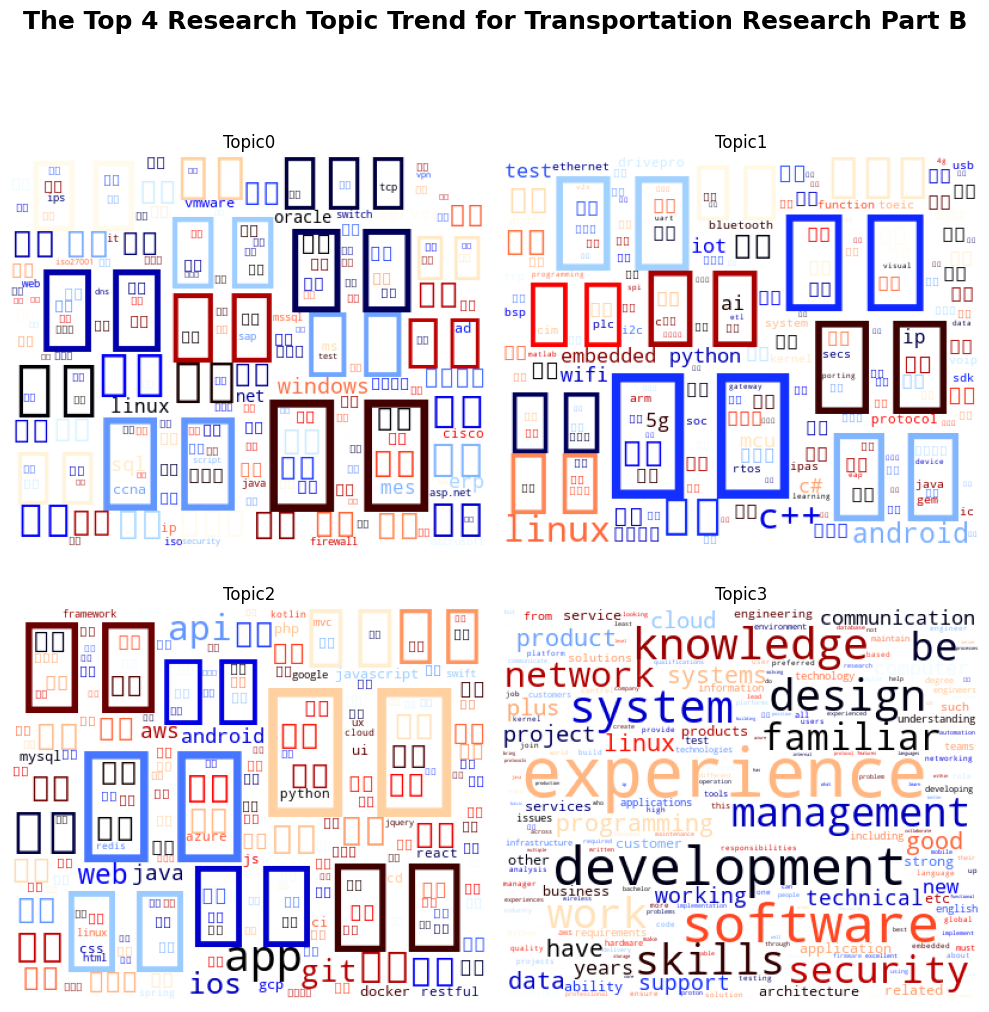

In [22]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors



cloud = WordCloud(
                  background_color='white',
                  prefer_horizontal=1,
                  height=330,
                  max_words=200,
                  colormap='flag',
                  collocations=True)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2,2 , figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    plt.imshow(cloud.fit_words(dict(lda_model.show_topic(i, 200))))
    plt.gca().set_title('Topic' + str(i), fontdict=dict(size=12))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.suptitle("The Top 4 Research Topic Trend for Transportation Research Part B", 
             y=1.05,
             fontsize=18,
             fontweight='bold'
             )
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [23]:
# 將 職缺 I 中的所有關鍵字統計成字典

uniqueWords_c1 = set()
for i in range(len(job7_c1)):
    a = job7_c1.loc[i,"content"]
    uniqueWords_c1 = uniqueWords_c1.union(set(a))



In [24]:
# 職缺 I 的 bag of word 統計
numOfWords_c1 = dict.fromkeys(uniqueWords_c1, 0)

# 初始資料表
df_por = pd.DataFrame(
{'por':numOfWords_c1}
)


for i in range(len(job7_c1)):
    a = job7_c1.loc[i,"content"]
    for word in a:
        numOfWords_c1[word] += 1

    # 第i職缺
    df = pd.DataFrame({i:numOfWords_c1}) 
    df_por = pd.concat([df_por, df], axis = 1)

    # 初始化
    numOfWords_c1 = dict.fromkeys(uniqueWords_c1, 0)



In [25]:
df_por.drop('por', axis=1, inplace=True)
df_por

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
80x86,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ability,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
able,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
about,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
accelerate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
風險,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
驗證,1,0,0,7,0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
體間,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
高度,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df_por[0].to_dict()

{'80x86': 0,
 'ability': 0,
 'able': 0,
 'about': 0,
 'accelerate': 0,
 'accordingly': 0,
 'accountability': 0,
 'acpi': 0,
 'across': 0,
 'actively': 0,
 'activities': 0,
 'adaptation': 0,
 'advances': 0,
 'against': 0,
 'agesa': 0,
 'aging': 0,
 'all': 0,
 'also': 0,
 'ambitious': 0,
 'amd': 0,
 'ami': 0,
 'amibcp': 0,
 'amiveb': 0,
 'aml': 0,
 'among': 0,
 'analog': 0,
 'analysis': 0,
 'analytical': 0,
 'analyzers': 0,
 'analyzes': 0,
 'android': 0,
 'annual': 0,
 'any': 0,
 'api': 0,
 'application': 0,
 'applications': 0,
 'apps': 0,
 'aptio4': 0,
 'aptio5': 0,
 'aptitude': 0,
 'architect': 0,
 'architecture': 0,
 'architectureknowledge': 0,
 'architectures': 0,
 'arduino': 0,
 'areas': 0,
 'arm': 0,
 'assembley': 0,
 'assembly': 0,
 'assigned': 0,
 'assisting': 0,
 'assurance': 0,
 'attend': 0,
 'automatic': 0,
 'average': 0,
 'awesome': 0,
 'bachelor': 0,
 'background': 0,
 'backgroundexperience': 0,
 'base': 0,
 'based': 0,
 'basic': 0,
 'basis': 0,
 'be': 0,
 'behavior': 0,
 'b

## TF

In [27]:
def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict

In [28]:
numOfWords_c1 = dict.fromkeys(uniqueWords_c1, 0)

df_TF = pd.DataFrame(
{'TF_por':numOfWords_c1}
)

for i in range(len(job7_c1)):
    a = job7_c1.loc[i,'content']

    # 第i職缺
    df = pd.DataFrame({i:computeTF(df_por[i].to_dict(),a)}) 
    df_TF = pd.concat([df_TF, df], axis = 1)

    # 初始化
    df = dict.fromkeys(uniqueWords_c1, 0)
    


df_TF

,TF_por,0,1,2,3,4,5,6,7,8,...,45,46,47,48,49,50,51,52,53,54
80x86,0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ability,0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.027027,0.000000,0.0,0.0,0.0,0.0,0.0
able,0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
about,0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
accelerate,0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
風險,0,0.00000,0.000000,0.0,0.003802,0.0,0.002439,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.013333,0.0,0.0,0.0,0.0,0.0
驗證,0,0.03125,0.000000,0.0,0.026616,0.0,0.014634,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
體間,0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
高度,0,0.00000,0.022727,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [29]:
df_TF.drop('TF_por', axis=1, inplace=True)
df_TF

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
80x86,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ability,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.027027,0.000000,0.0,0.0,0.0,0.0,0.0
able,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
about,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
accelerate,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
風險,0.00000,0.000000,0.0,0.003802,0.0,0.002439,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.013333,0.0,0.0,0.0,0.0,0.0
驗證,0.03125,0.000000,0.0,0.026616,0.0,0.014634,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
體間,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
高度,0.00000,0.022727,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


## IDF

In [30]:
def computeIDF(documents):
    import math
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

In [31]:
df_por_list = [] 

for i in range(len(job7_c1)):
    df_por_list.append(df_por[i].to_dict())


idfs = computeIDF(df_por_list)



In [32]:
df_idfs = pd.DataFrame({'idf':idfs},)
df_idfs.sort_values(by=["idf"],ascending=False)


,idf
80x86,4.007333
skillsexcellent,4.007333
series,4.007333
serious,4.007333
serve,4.007333
...,...
維護,0.541597
設計,0.480973
經驗,0.480973
開發,0.269664


# TFIDF

In [33]:
def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [34]:
tfidf_list = []
for i in range(len(df_por.columns)):
    tfidf = computeTFIDF(df_por[i].to_dict(), idfs)
    tfidf_list.append(tfidf)

df_tfidf = pd.DataFrame(tfidf_list).T

df_tfidf


,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
80x86,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ability,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.908721,0.000000,0.0,0.0,0.0,0.0,0.0
able,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
about,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
accelerate,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
風險,0.000000,0.000000,0.0,2.908721,0.0,2.908721,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,2.908721,0.0,0.0,0.0,0.0,0.0
驗證,2.061423,0.000000,0.0,14.429961,0.0,12.368538,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
體間,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
高度,0.000000,4.007333,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [35]:
df_por[0].to_dict()
idfs


{'80x86': 4.007333185232471,
 'ability': 2.908720896564361,
 'able': 4.007333185232471,
 'about': 4.007333185232471,
 'accelerate': 4.007333185232471,
 'accordingly': 4.007333185232471,
 'accountability': 4.007333185232471,
 'acpi': 2.3978952727983707,
 'across': 4.007333185232471,
 'actively': 4.007333185232471,
 'activities': 4.007333185232471,
 'adaptation': 4.007333185232471,
 'advances': 4.007333185232471,
 'against': 4.007333185232471,
 'agesa': 4.007333185232471,
 'aging': 3.3141860046725258,
 'all': 2.6210388241125804,
 'also': 4.007333185232471,
 'ambitious': 4.007333185232471,
 'amd': 2.908720896564361,
 'ami': 1.927891643552635,
 'amibcp': 4.007333185232471,
 'amiveb': 4.007333185232471,
 'aml': 4.007333185232471,
 'among': 4.007333185232471,
 'analog': 4.007333185232471,
 'analysis': 3.3141860046725258,
 'analytical': 3.3141860046725258,
 'analyzers': 4.007333185232471,
 'analyzes': 4.007333185232471,
 'android': 3.3141860046725258,
 'annual': 4.007333185232471,
 'any': 4.0

In [36]:
tfidf = computeTFIDF(df_por[10].to_dict(), idfs)
tfidf

pd.DataFrame({'tfidf':tfidf})


,tfidf
80x86,0.0
ability,0.0
able,0.0
about,0.0
accelerate,0.0
...,...
風險,0.0
驗證,0.0
體間,0.0
高度,0.0


## 以下皆為測試

In [37]:
# 建立職群 bag of word
lst = [job7_c1, job7_c2, job7_c3, job7_c4]

BoW_c1 = []
BoW_c2 = []
BoW_c3 = []
BoW_c4 = []

for i in range(len(job7_c1)):
    for j in job7_c1.loc[i, 'content']:
        BoW_c1.append(j)

for i in range(len(job7_c2)):
    for j in job7_c2.loc[i, 'content']:
        BoW_c2.append(j)

for i in range(len(job7_c3)):
    for j in job7_c3.loc[i, 'content']:
        BoW_c3.append(j)

for i in range(len(job7_c4)):
    for j in job7_c4.loc[i, 'content']:
        BoW_c4.append(j)



In [38]:
# 剔除重複詞
uniqueWords_c1 = set(BoW_c1)
uniqueWords_c2 = set(BoW_c2)
uniqueWords_c3 = set(BoW_c3)
uniqueWords_c4 = set(BoW_c4)

print(len(BoW_c4))
print(len(uniqueWords_c4))


160933
13519


In [39]:
# 建立詞庫字典並統計詞袋中每個單詞的數量
  
numOfWords_c1 = dict.fromkeys(uniqueWords_c1, 0)
for word in BoW_c1:
    numOfWords_c1[word] += 1

numOfWords_c2 = dict.fromkeys(uniqueWords_c2, 0)
for word in BoW_c2:
    numOfWords_c2[word] += 1

numOfWords_c3 = dict.fromkeys(uniqueWords_c3, 0)
for word in BoW_c3:
    numOfWords_c3[word] += 1

numOfWords_c4 = dict.fromkeys(uniqueWords_c4, 0)
for word in BoW_c4:
    numOfWords_c4[word] += 1




numOfWords_c1
numOfWords_c2
numOfWords_c3
numOfWords_c4


{'offensive': 1,
 '參閱': 2,
 '智能化': 1,
 '願意': 94,
 '計劃': 78,
 '熱愛': 17,
 'dbs': 1,
 '資訊以': 1,
 '整個': 26,
 'source': 33,
 'vscode': 1,
 '函式': 3,
 '情緒': 6,
 '閱制': 1,
 'fight': 2,
 '黑箱': 2,
 '發放三節': 3,
 '托嬰': 1,
 '非短': 3,
 '金融界': 6,
 'chef': 3,
 '加上': 2,
 '采集': 2,
 '具團隊': 26,
 '努力': 19,
 '造模': 1,
 'humans': 1,
 'seen': 1,
 '具下': 1,
 'modem': 10,
 'peers': 2,
 '確保即': 1,
 '資訊正': 1,
 '時效性': 1,
 'keyvalue': 1,
 '完整': 40,
 '安心': 4,
 '高可用性': 10,
 '非為': 1,
 'quick': 4,
 '建廠': 1,
 'sub': 3,
 '正取': 1,
 '已導入': 3,
 '哪一種': 1,
 'necessarypreferred': 1,
 'disposition': 1,
 '無人車': 1,
 'converters': 1,
 '依據學': 2,
 'mm': 7,
 '機制': 75,
 'internet': 29,
 '發為': 1,
 '阻擋': 2,
 'technoloies': 1,
 '亞太地區': 1,
 '放大': 1,
 '已到': 1,
 '威力': 1,
 'approachable': 1,
 'procedure': 6,
 '防呆卡控': 1,
 '依任務': 1,
 'website': 12,
 '公式': 3,
 'jd': 2,
 'filters': 1,
 '語意': 13,
 '資通網': 1,
 '作過': 1,
 '能團隊': 1,
 '有構': 1,
 'fragment': 1,
 'fixed': 2,
 '忙碌': 2,
 '廣告': 46,
 'agl': 1,
 '內核': 1,
 'middle': 1,
 'rp': 5,
 'outbound': 1,
 '交互'

# Term Frequency (TF)
The number of times a word appears in a document divded by the total number of words in the document. Every document has its own term frequency

In [40]:
def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict

In [41]:
# TF calculate

tf_c1 = computeTF(numOfWords_c1, BoW_c1)
tf_c2 = computeTF(numOfWords_c2, BoW_c2)
tf_c3 = computeTF(numOfWords_c3, BoW_c3)
tf_c4 = computeTF(numOfWords_c4, BoW_c4)

In [42]:
# TF dataframe
df_tf_c1 = pd.DataFrame([tf_c1], index=[0]).T
df_tf_c1 = df_tf_c1.rename(columns={0:"TF"})

df_tf_c2 = pd.DataFrame([tf_c2], index=[0]).T
df_tf_c2 = df_tf_c2.rename(columns={0:"TF"})

df_tf_c3 = pd.DataFrame([tf_c3], index=[0]).T
df_tf_c3 = df_tf_c3.rename(columns={0:"TF"})

df_tf_c4 = pd.DataFrame([tf_c4], index=[0]).T
df_tf_c4 = df_tf_c4.rename(columns={0:"TF"})



In [43]:
df_tf_c2.sort_values(by=["TF"],ascending=False)[:50]

,TF
開發,0.031939
經驗,0.020797
設計,0.019758
系統,0.019387
程式,0.019130
軟體,0.014957
能力,0.008475
技術,0.006992
資料庫,0.006826
維護,0.006595


# Inverse Data Frequency (IDF)
The log of the number of documents divided by the number of documents that contain the word w. Inverse data frequency determines the weight of rare words across all documents in the corpus

In [44]:
import math

In [45]:
def computeIDF(documents):
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

In [46]:
# idfs = computeIDF([numOfWords_c1, numOfWords_c2, numOfWords_c3, numOfWords_c4])

In [47]:
idfs

{'80x86': 4.007333185232471,
 'ability': 2.908720896564361,
 'able': 4.007333185232471,
 'about': 4.007333185232471,
 'accelerate': 4.007333185232471,
 'accordingly': 4.007333185232471,
 'accountability': 4.007333185232471,
 'acpi': 2.3978952727983707,
 'across': 4.007333185232471,
 'actively': 4.007333185232471,
 'activities': 4.007333185232471,
 'adaptation': 4.007333185232471,
 'advances': 4.007333185232471,
 'against': 4.007333185232471,
 'agesa': 4.007333185232471,
 'aging': 3.3141860046725258,
 'all': 2.6210388241125804,
 'also': 4.007333185232471,
 'ambitious': 4.007333185232471,
 'amd': 2.908720896564361,
 'ami': 1.927891643552635,
 'amibcp': 4.007333185232471,
 'amiveb': 4.007333185232471,
 'aml': 4.007333185232471,
 'among': 4.007333185232471,
 'analog': 4.007333185232471,
 'analysis': 3.3141860046725258,
 'analytical': 3.3141860046725258,
 'analyzers': 4.007333185232471,
 'analyzes': 4.007333185232471,
 'android': 3.3141860046725258,
 'annual': 4.007333185232471,
 'any': 4.0